# Simple feed forward network

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from torch.optim.lr_scheduler import ExponentialLR
from torch.optim import Adam
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

c:\Users\sruth\anaconda3\envs\recons\lib\site-packages\scipy\__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
filtered_data = pd.read_csv('source_events_50.csv')


# Step 1: Add additional features (sin(Theta), cos(Theta), distance between planes)
def add_new_features(df):
    df['sin_Theta'] = np.sin(df['Theta'])
    df['cos_Theta'] = np.cos(df['Theta'])
    df['distance'] = np.sqrt((df['Scatter_X'] - df['Absorb_X'])**2 + (df['Scatter_Y'] - df['Absorb_Y'])**2)
    df = df.drop(columns=['Theta'])  # Drop Theta if not needed
    return df

In [4]:
filtered_data = add_new_features(filtered_data)

# Step 2: Prepare the data for training
X = filtered_data[['Scatter_X', 'Scatter_Y', 'Absorb_X', 'Absorb_Y', 'sin_Theta', 'cos_Theta', 'distance']]
y = filtered_data[['Source_X', 'Source_Y']]

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalize the feature data
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Convert data to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(np.array(y_train), dtype=torch.float32)
y_test = torch.tensor(np.array(y_test), dtype=torch.float32)

In [7]:
class GammaRayModel(nn.Module):
    def __init__(self, input_dim):
        super(GammaRayModel, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 2)  # Output layer with 2 neurons
        )
    
    def forward(self, x):
        return self.network(x)
    
# Function to create the model, optimizer, and loss function
def create_gamma_ray_model(input_dim, learning_rate=0.001):
    model = GammaRayModel(input_dim)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.MSELoss()
    return model, optimizer, criterion



In [5]:
X_train.shape[1]

7

In [8]:
input_dim = X_train.shape[1]
model, optimizer, criterion = create_gamma_ray_model(input_dim)

In [16]:
# Set the model to training mode
model.train()


epochs = 500

for epoch in range(epochs):
    optimizer.zero_grad()
    outputs = model(X_train)
    loss = criterion(outputs, y_train)
    loss.backward()
    optimizer.step()
    train_r2 = r2_score(y_train, outputs)
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}, R^2: {train_r2:.4f}')

Epoch [10/500], Loss: 129.1371, R^2: 0.0017
Epoch [20/500], Loss: 129.1334, R^2: 0.0017
Epoch [30/500], Loss: 129.1297, R^2: 0.0017
Epoch [40/500], Loss: 129.1286, R^2: 0.0018
Epoch [50/500], Loss: 129.1232, R^2: 0.0018
Epoch [60/500], Loss: 129.1186, R^2: 0.0018
Epoch [70/500], Loss: 129.1159, R^2: 0.0019
Epoch [80/500], Loss: 129.1127, R^2: 0.0019
Epoch [90/500], Loss: 129.1126, R^2: 0.0019
Epoch [100/500], Loss: 129.1075, R^2: 0.0019
Epoch [110/500], Loss: 129.1030, R^2: 0.0020
Epoch [120/500], Loss: 129.0999, R^2: 0.0020
Epoch [130/500], Loss: 129.0966, R^2: 0.0020
Epoch [140/500], Loss: 129.0982, R^2: 0.0020
Epoch [150/500], Loss: 129.0925, R^2: 0.0020
Epoch [160/500], Loss: 129.0889, R^2: 0.0021
Epoch [170/500], Loss: 129.0856, R^2: 0.0021
Epoch [180/500], Loss: 129.0823, R^2: 0.0021
Epoch [190/500], Loss: 129.0799, R^2: 0.0021
Epoch [200/500], Loss: 129.0774, R^2: 0.0021
Epoch [210/500], Loss: 129.0792, R^2: 0.0021
Epoch [220/500], Loss: 129.0737, R^2: 0.0022
Epoch [230/500], Lo

In [17]:
#write test code here
model.eval()
with torch.no_grad():
    y_pred = model(X_test)
    test_loss = criterion(y_pred, y_test)
    test_r2 = r2_score(y_test, y_pred)
    print(f'Test Loss: {test_loss.item():.4f}, Test R^2: {test_r2:.4f}')

Test Loss: 129.1389, Test R^2: -0.0025


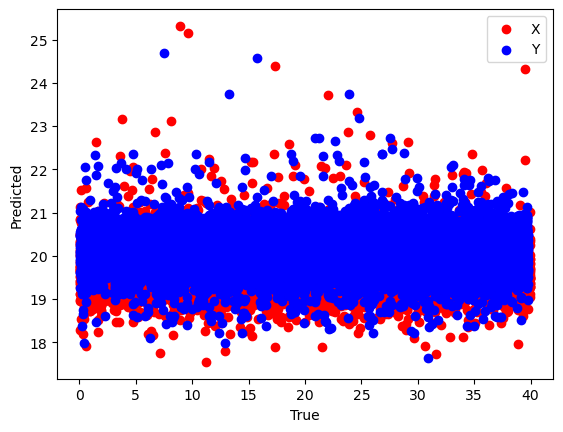

In [19]:
# plot the results
import matplotlib.pyplot as plt
plt.scatter(y_test[:, 0], y_pred[:, 0], label='X', color='r')
plt.scatter(y_test[:, 1], y_pred[:, 1], label='Y', color='b')
plt.xlabel('True')
plt.ylabel('Predicted')
plt.legend()
plt.show()
